In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.optimize as opt
import scipy
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import random
import sklearn
%matplotlib inline

In [256]:
path = os.getcwd()
data = loadmat(path+"\ex8data1.mat")
data.keys()

['yval', '__header__', '__globals__', 'Xval', 'X', '__version__']

In [257]:
X = data['X']
X.shape

(307L, 2L)

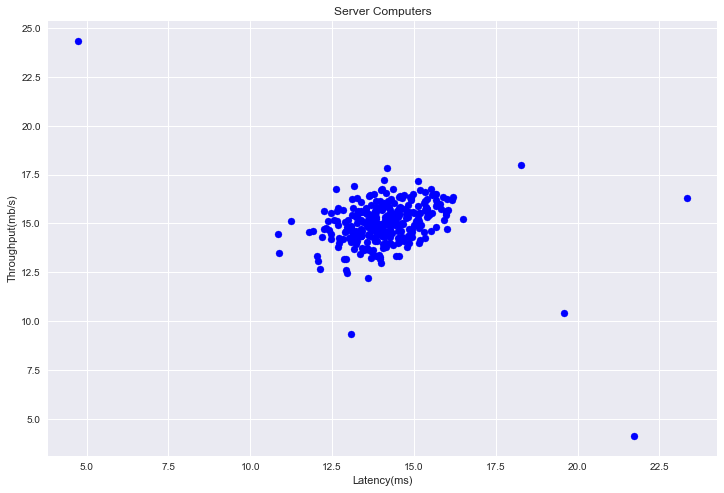

In [258]:
plt.figure(figsize=(12,8))
plt.scatter(X[:,0],X[:,1],c = 'b')
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.title("Server Computers")

# Gaussian Distribution 
<img src = 'gaussian.png'>
<img src = 'mu.png'>
<img src = 'var.png'>
<img src = 'multi.png'>

In [259]:
def estimateGaussian(DATA):
    mu = np.mean(DATA,axis = 0)
    sigma2 = np.var(DATA,axis=0)
    return mu,sigma2

In [260]:
mu, var = estimateGaussian(X)
mu, var

(array([ 14.11222578,  14.99771051]), array([ 1.83263141,  1.70974533]))

In [261]:
def multivariateGaussian(myX, mymu, mysig2):

    m = myX.shape[0]
    n = myX.shape[1]
    if np.ndim(mysig2) == 1:
        mysig2 = np.diag(mysig2)

    norm = 1./(np.power((2*np.pi), n/2)*np.sqrt(np.linalg.det(mysig2)))
    myinv = np.linalg.inv(mysig2)
    myexp = np.zeros((m,1))
    for irow in xrange(m):
        xrow = myX[irow]
        myexp[irow] = np.exp(-0.5*((xrow-mymu).T).dot(myinv).dot(xrow-mymu))
    return norm*myexp

In [262]:
#Built in Functions to get probabilities for gaussian dist
from scipy.stats import multivariate_normal
dist1 = multivariate_normal(mu, np.diag(var))
print dist1.pdf(X)[:10]

from scipy import stats
dist2 = stats.norm(mu, var)
print dist2.pdf(X)[:10]
print multivariateGaussian(X,mu,var)[:10]

[ 0.06470829  0.05030417  0.07245035  0.05031575  0.06368497  0.04245832
  0.04790945  0.03651115  0.0186658   0.05068826]
[[ 0.183842    0.23072208]
 [ 0.20221694  0.17979697]
 [ 0.21746136  0.20588081]
 [ 0.19778763  0.18414102]
 [ 0.20858956  0.19964116]
 [ 0.21652359  0.15131762]
 [ 0.16991291  0.21058001]
 [ 0.15123542  0.20352195]
 [ 0.1163989   0.18199769]
 [ 0.1594734   0.23294643]]
[[ 0.06470829]
 [ 0.05030417]
 [ 0.07245035]
 [ 0.05031575]
 [ 0.06368497]
 [ 0.04245832]
 [ 0.04790945]
 [ 0.03651115]
 [ 0.0186658 ]
 [ 0.05068826]]


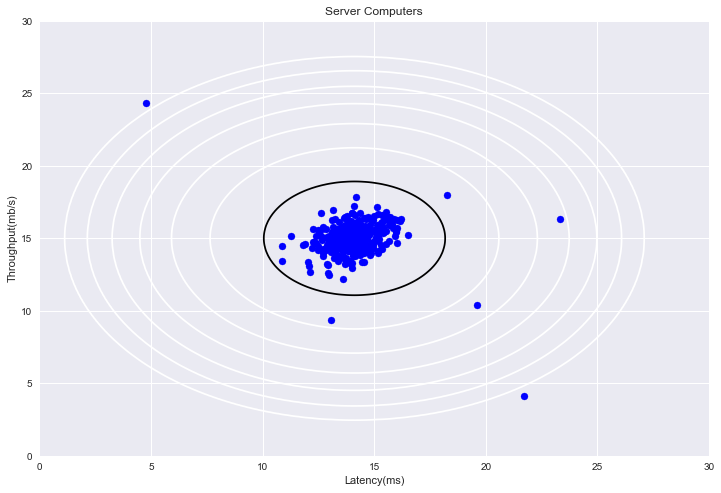

In [271]:
xs, ys = np.mgrid[0:30:0.1, 0:30:0.1]
pos = np.empty(xs.shape + (2,))
pos[:, :, 0] = xs
pos[:, :, 1] = ys

plt.figure(figsize=(12,8))
plt.scatter(X[:,0],X[:,1],c = 'b')
plt.contour(xs, ys, dist1.pdf(pos), 10.**np.arange(-21, -2, 3))
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.title("Server Computers")

## Slect Threshold Using Validation Set and F1 Score:
<img src = 'threshold.png'>

In [263]:
def selectThreshold(Yval,pval):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    
    stepsize = (pval.max() - pval.min())/1000
    epsilons = np.arange(pval.min(),pval.max(),stepsize)
    for epsilon in epsilons:
        
        prediction = pval < epsilon
        
        truepos = np.sum((prediction == 1) & (Yval == 1)).astype(float)
        falsepos = np.sum((prediction == 1) & (Yval == 0)).astype(float)
        falseneg = np.sum((prediction == 0) & (Yval == 1)).astype(float)
        
        precision = truepos/(truepos+falsepos)
        recall = truepos/(truepos+falseneg)
        
        F1 = (2*precision*recall)/(precision+recall)
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon,bestF1

In [264]:
#Get Threshold
Xval = data['Xval']
Yval = data['yval']
pval = dist1.pdf(Xval).reshape(len(Xval),1)
#pval = multivariateGaussian(Xval,mu,var) 
epsilon, F1 = selectThreshold(Yval,pval)
epsilon , F1

C:\Users\stiwari\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars


(8.9908527792694932e-05, 0.87500000000000011)

In [265]:
#Get Outliers
p = dist1.pdf(X).reshape(len(X),1)
#p = multivariateGaussian(X,mu,var)
idx = np.where(p < epsilon)
idx = p < epsilon
outliers = X[idx.ravel()]
outliers

array([[ 13.07931049,   9.34787812],
       [ 21.72713402,   4.12623222],
       [ 19.58257277,  10.411619  ],
       [ 23.33986753,  16.29887355],
       [ 18.26118844,  17.978309  ],
       [  4.75261282,  24.35040725]])

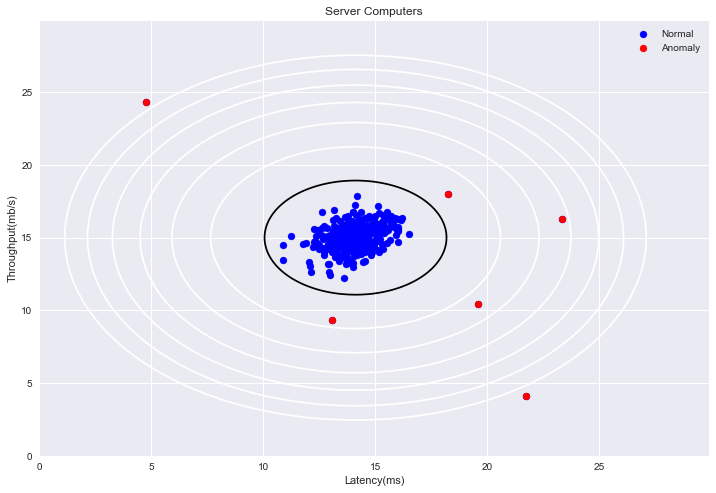

In [272]:
plt.figure(figsize=(12,8))
plt.scatter(X[:,0],X[:,1],c = 'b',label = 'Normal')
plt.scatter(outliers[:,0],outliers[:,1],c = 'r',label = 'Anomaly')
plt.contour(xs, ys, dist1.pdf(pos), 10.**np.arange(-21, -2, 3))
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.legend()
plt.title("Server Computers")

## High Dimensional Data

In [214]:
data2 = loadmat(path+'\ex8data2.mat')
data2.keys()

['yval', '__header__', '__globals__', 'Xval', 'X', '__version__']

In [232]:
X = data2['X']
Xval = data2['Xval']
yval = data2['yval']
X.shape

(1000L, 11L)

In [222]:
mu, var = estimateGaussian(X)

pval = multivariateGaussian(Xval,mu, var)
bestepsilon, bestF1 = selectThreshold(yval, pval)

p = multivariateGaussian(X,mu,var)
idx = p < bestepsilon
outliers = X[idx.ravel()]

C:\Users\stiwari\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars


In [224]:
print "Epsilon = ", bestepsilon
print "F1 =", bestF1
print "Outliers =", len(outliers)

Epsilon =  3.43824343126e-18
F1 = 0.615384615385
Outliers = 117
